In [26]:
NEED_TO_INSTALL_PACKAGES = False
if NEED_TO_INSTALL_PACKAGES:
    ! pip install bilby lalsimulation lalsuite
import bilby

In [2]:
from bilby.gw import conversion

#calculate the chirp mass from the component masses
chirp_mass = conversion.component_masses_to_chirp_mass(mass_1=60, mass_2=50)
print(chirp_mass)

47.642464144804954


In [7]:
POSSIBLE_KEYS = bilby.gw.prior.BBHPriorDict(aligned_spin=True).keys()
print(POSSIBLE_KEYS)

12:14 bilby INFO    : Using aligned spin prior
12:14 bilby INFO    : No prior given, using default BBH priors in /gpfs/home2/bhardwaj/venvs/tmnre_lvc/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


dict_keys(['mass_1', 'mass_2', 'mass_ratio', 'chirp_mass', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'chi_1', 'chi_2'])


In [16]:
### LET US SETUP SOME INJECTION PARAMETERS
injection_parameters = dict(
    mass_1 = 60,
    mass_2 = 50,
    mass_ratio = 0.8, #m2/m1
    chirp_mass = 47.642464144804954,
    chi_1 = 0.2,
    chi_2 = 0.3,
    luminosity_distance = 400,
    theta_jn = 1.4,
    psi = 2.0,
    ra = 1.375,
    dec = -0.7,
    phase = 1.2,
    geocent_time = 100,
)

In [9]:
waveform_arguments = dict(
    waveform_approximant = 'IMRPhenomPv2',
    reference_frequency = 50,
    minimum_frequency = 20,
    sampling_frequency = 1024,
    duration = 4,
    start_time = injection_parameters['geocent_time'] - 2,
)

In [10]:
waveform_generator = bilby.gw.WaveformGenerator(
    duration = waveform_arguments['duration'],
    sampling_frequency = waveform_arguments['sampling_frequency'],
    frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
    parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments = waveform_arguments,
)

12:20 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


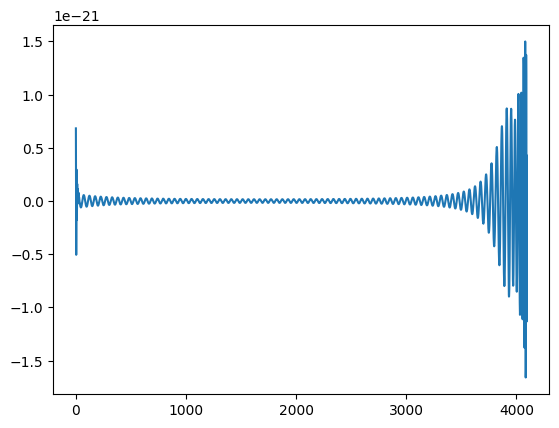

In [25]:
import matplotlib.pyplot as plt
plt.plot(waveform_generator.time_domain_strain(injection_parameters)['plus'])